In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [19]:
import warnings
warnings.simplefilter('ignore')

### Read data

In [2]:
data_train = pd.read_csv('customer_churn_dataset-training-master.csv')
data_test = pd.read_csv('customer_churn_dataset-testing-master.csv')

In [3]:
data_train

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.00,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.00,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.00,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.00,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.00,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
440828,449995.0,42.0,Male,54.0,15.0,1.0,3.0,Premium,Annual,716.38,8.0,0.0
440829,449996.0,25.0,Female,8.0,13.0,1.0,20.0,Premium,Annual,745.38,2.0,0.0
440830,449997.0,26.0,Male,35.0,27.0,1.0,5.0,Standard,Quarterly,977.31,9.0,0.0
440831,449998.0,28.0,Male,55.0,14.0,2.0,0.0,Standard,Quarterly,602.55,2.0,0.0


In [4]:
data_test.head(5)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [6]:
data_train.nunique()

CustomerID           440832
Age                      48
Gender                    2
Tenure                   60
Usage Frequency          30
Support Calls            11
Payment Delay            31
Subscription Type         3
Contract Length           3
Total Spend           68363
Last Interaction         30
Churn                     2
dtype: int64

#### Preprocess data

In [7]:
data_train.isna().sum()

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [8]:
data_train = data_train.dropna()
data_train.isna().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [9]:
def isMale(gender: str) -> int:
    return 1 if gender == 'Male' else 0

Train

In [10]:
data_train = data_train.drop(columns='CustomerID')
data_train['Gender'] = data_train['Gender'].apply(isMale)
data_train.head(5)

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,0,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,65.0,0,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,55.0,0,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,58.0,1,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,23.0,1,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


Test

In [31]:
data_test = data_test.drop(columns='CustomerID')
data_test['Gender'] = data_test['Gender'].apply(isMale)
data_test.head(5)

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,22,0,25,14,4,27,Basic,Monthly,598,9,1
1,41,0,28,28,7,13,Standard,Monthly,584,20,0
2,47,1,27,10,2,29,Premium,Annual,757,21,0
3,35,1,9,12,5,17,Premium,Quarterly,232,18,0
4,53,0,58,24,9,2,Standard,Annual,533,18,0


#### Encode data (One-Hot)

Train

In [11]:
data_train = pd.get_dummies(data_train, columns=data_train.select_dtypes(include=['object']).columns.tolist(), drop_first=True)

In [12]:
numeric_columns = data_train.select_dtypes(include=['int64', 'float64']).columns.tolist()[:-1]

In [13]:
scaler = StandardScaler()
data_train[numeric_columns] = scaler.fit_transform(data_train[numeric_columns])

In [32]:
data_train.head(5)

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Monthly,Contract Length_Quarterly
0,-0.753326,-1.145909,0.448760,-0.210511,0.454549,0.609620,1.247427,0.293052,1.0,False,True,False,False
1,2.059646,-1.145909,1.028278,-1.724562,2.083100,-0.601319,-0.309865,-0.986584,1.0,False,False,True,False
2,1.255940,-1.145909,-1.000036,-1.375166,0.780259,0.609620,-1.854698,-1.335575,1.0,False,False,False,True
3,1.497051,0.872670,0.390808,0.604748,1.105969,-0.722413,-0.978462,1.689018,1.0,False,True,True,False
4,-1.315921,0.872670,0.043097,0.488282,0.454549,-0.601319,-0.060698,0.642043,1.0,False,False,True,False


Test

In [34]:
data_test = pd.get_dummies(data_test, columns=data_test.select_dtypes(include=['object']).columns.tolist(), drop_first=True)

In [35]:
numeric_columns_test = data_test.select_dtypes(include=['int64', 'float64']).columns.tolist()[:-1]

In [37]:
data_test[numeric_columns_test] = scaler.fit_transform(data_test[numeric_columns_test])

In [38]:
data_test.head(5)

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Monthly,Contract Length_Quarterly
0,-1.434202,-0.934825,-0.409100,-0.122526,-0.449807,1.114538,0.218408,-0.752324,1,False,False,True,False
1,-0.069730,-0.934825,-0.233642,1.465424,0.513590,-0.467000,0.164742,0.521065,0,False,True,True,False
2,0.361155,1.069719,-0.292128,-0.576225,-1.092072,1.340472,0.827900,0.636827,0,True,False,False,False
3,-0.500616,1.069719,-1.344876,-0.349375,-0.128674,-0.015132,-1.184575,0.289540,0,True,False,False,True
4,0.792041,-0.934825,1.520939,1.011724,1.155855,-1.709637,-0.030756,0.289540,0,False,True,False,False


### EDA

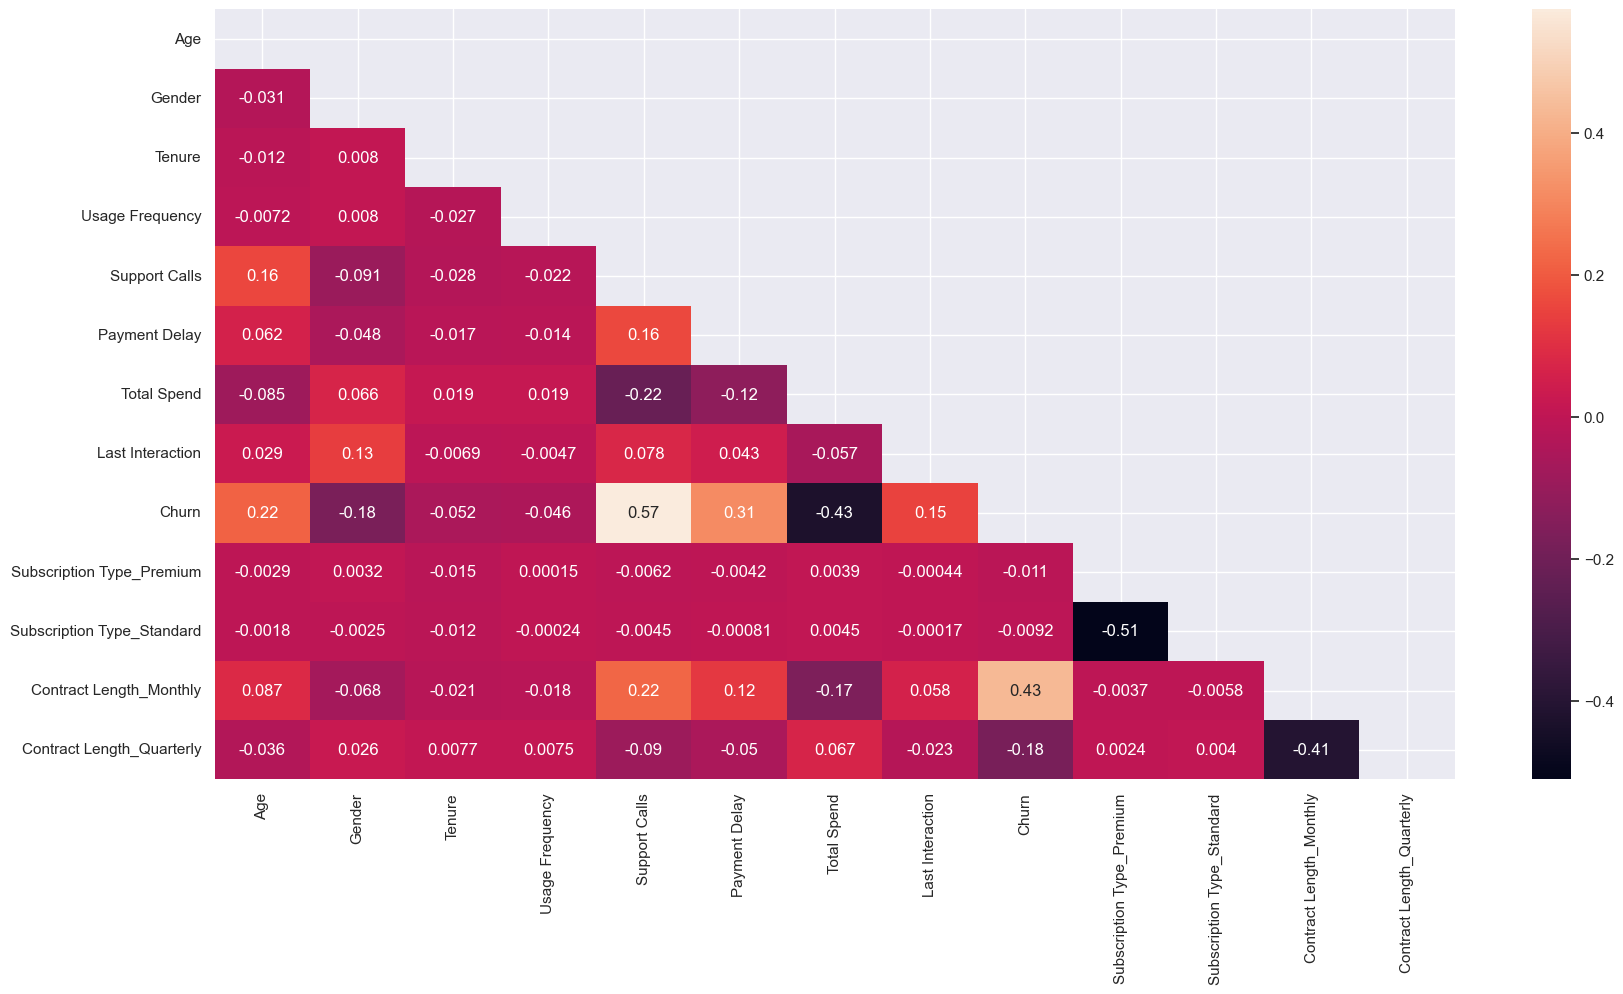

In [15]:
# Pearson heatmap

mask = np.zeros_like(data_train.corr(numeric_only=True))
mask[np.triu_indices_from(mask)] = True
sns.set(rc={'figure.figsize': (20, 10)})
sns.heatmap(data_train.corr(numeric_only=True, method='pearson'), annot=True, mask=mask);

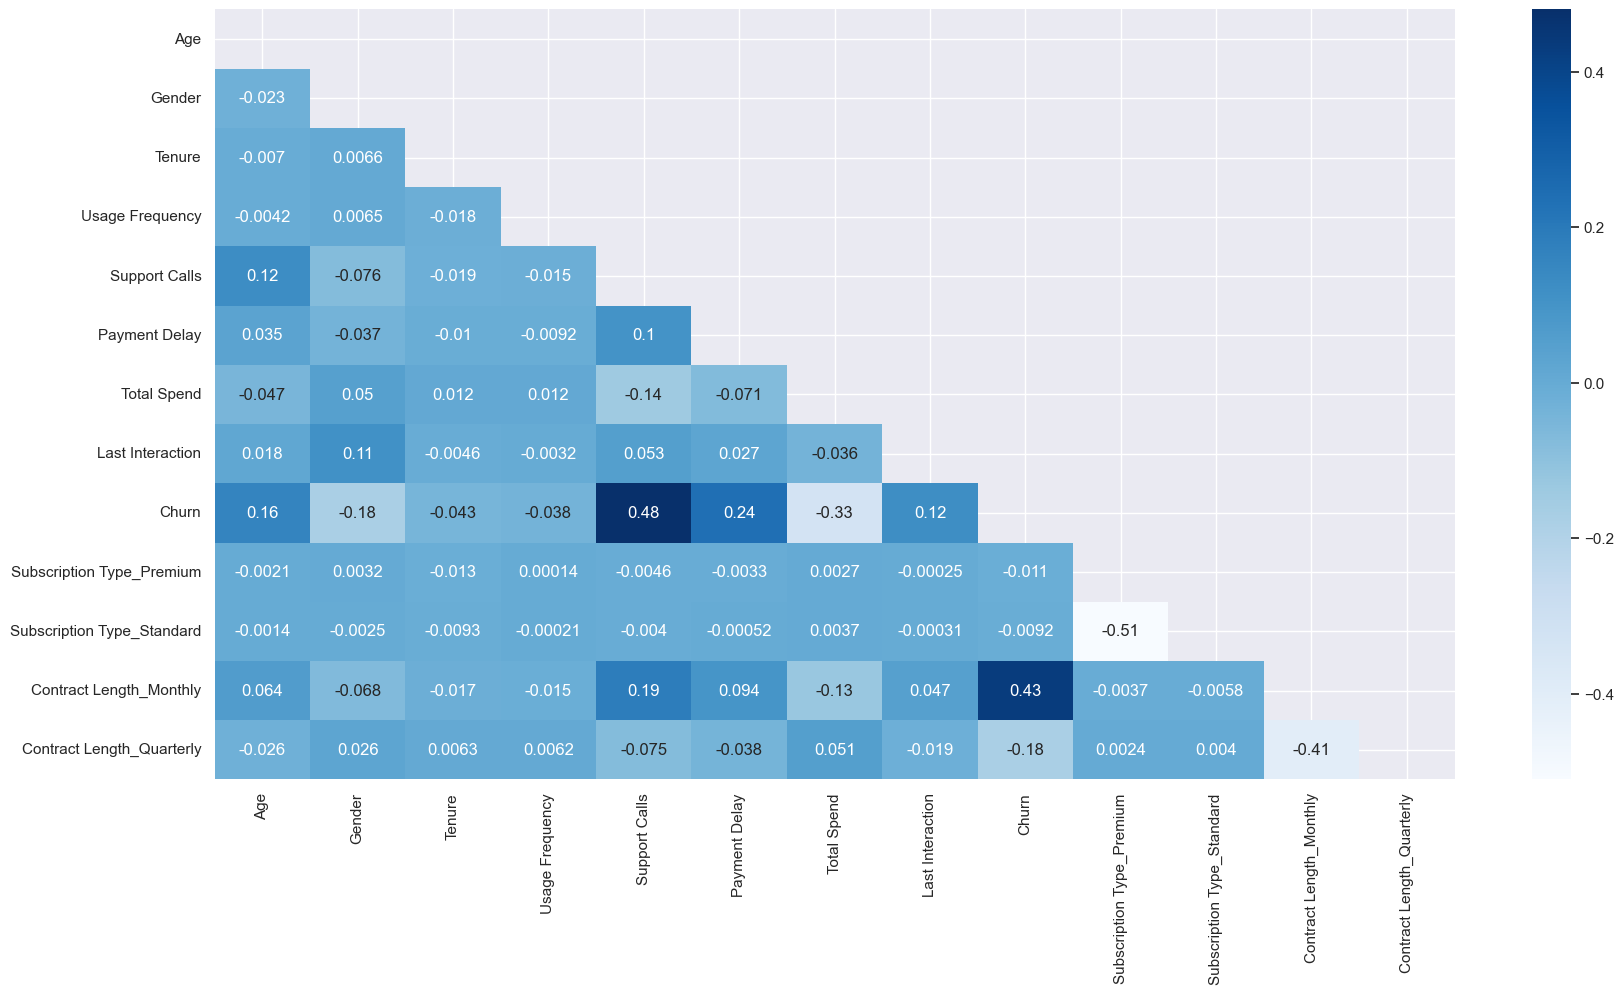

In [16]:
#Kendall heatmap

mask = np.zeros_like(data_train.corr(numeric_only=True))
mask[np.triu_indices_from(mask)] = True
sns.set(rc={'figure.figsize':(20, 10)})
sns.heatmap(data_train.corr(numeric_only=True, method='kendall'), annot=True, mask=mask, cmap='Blues');

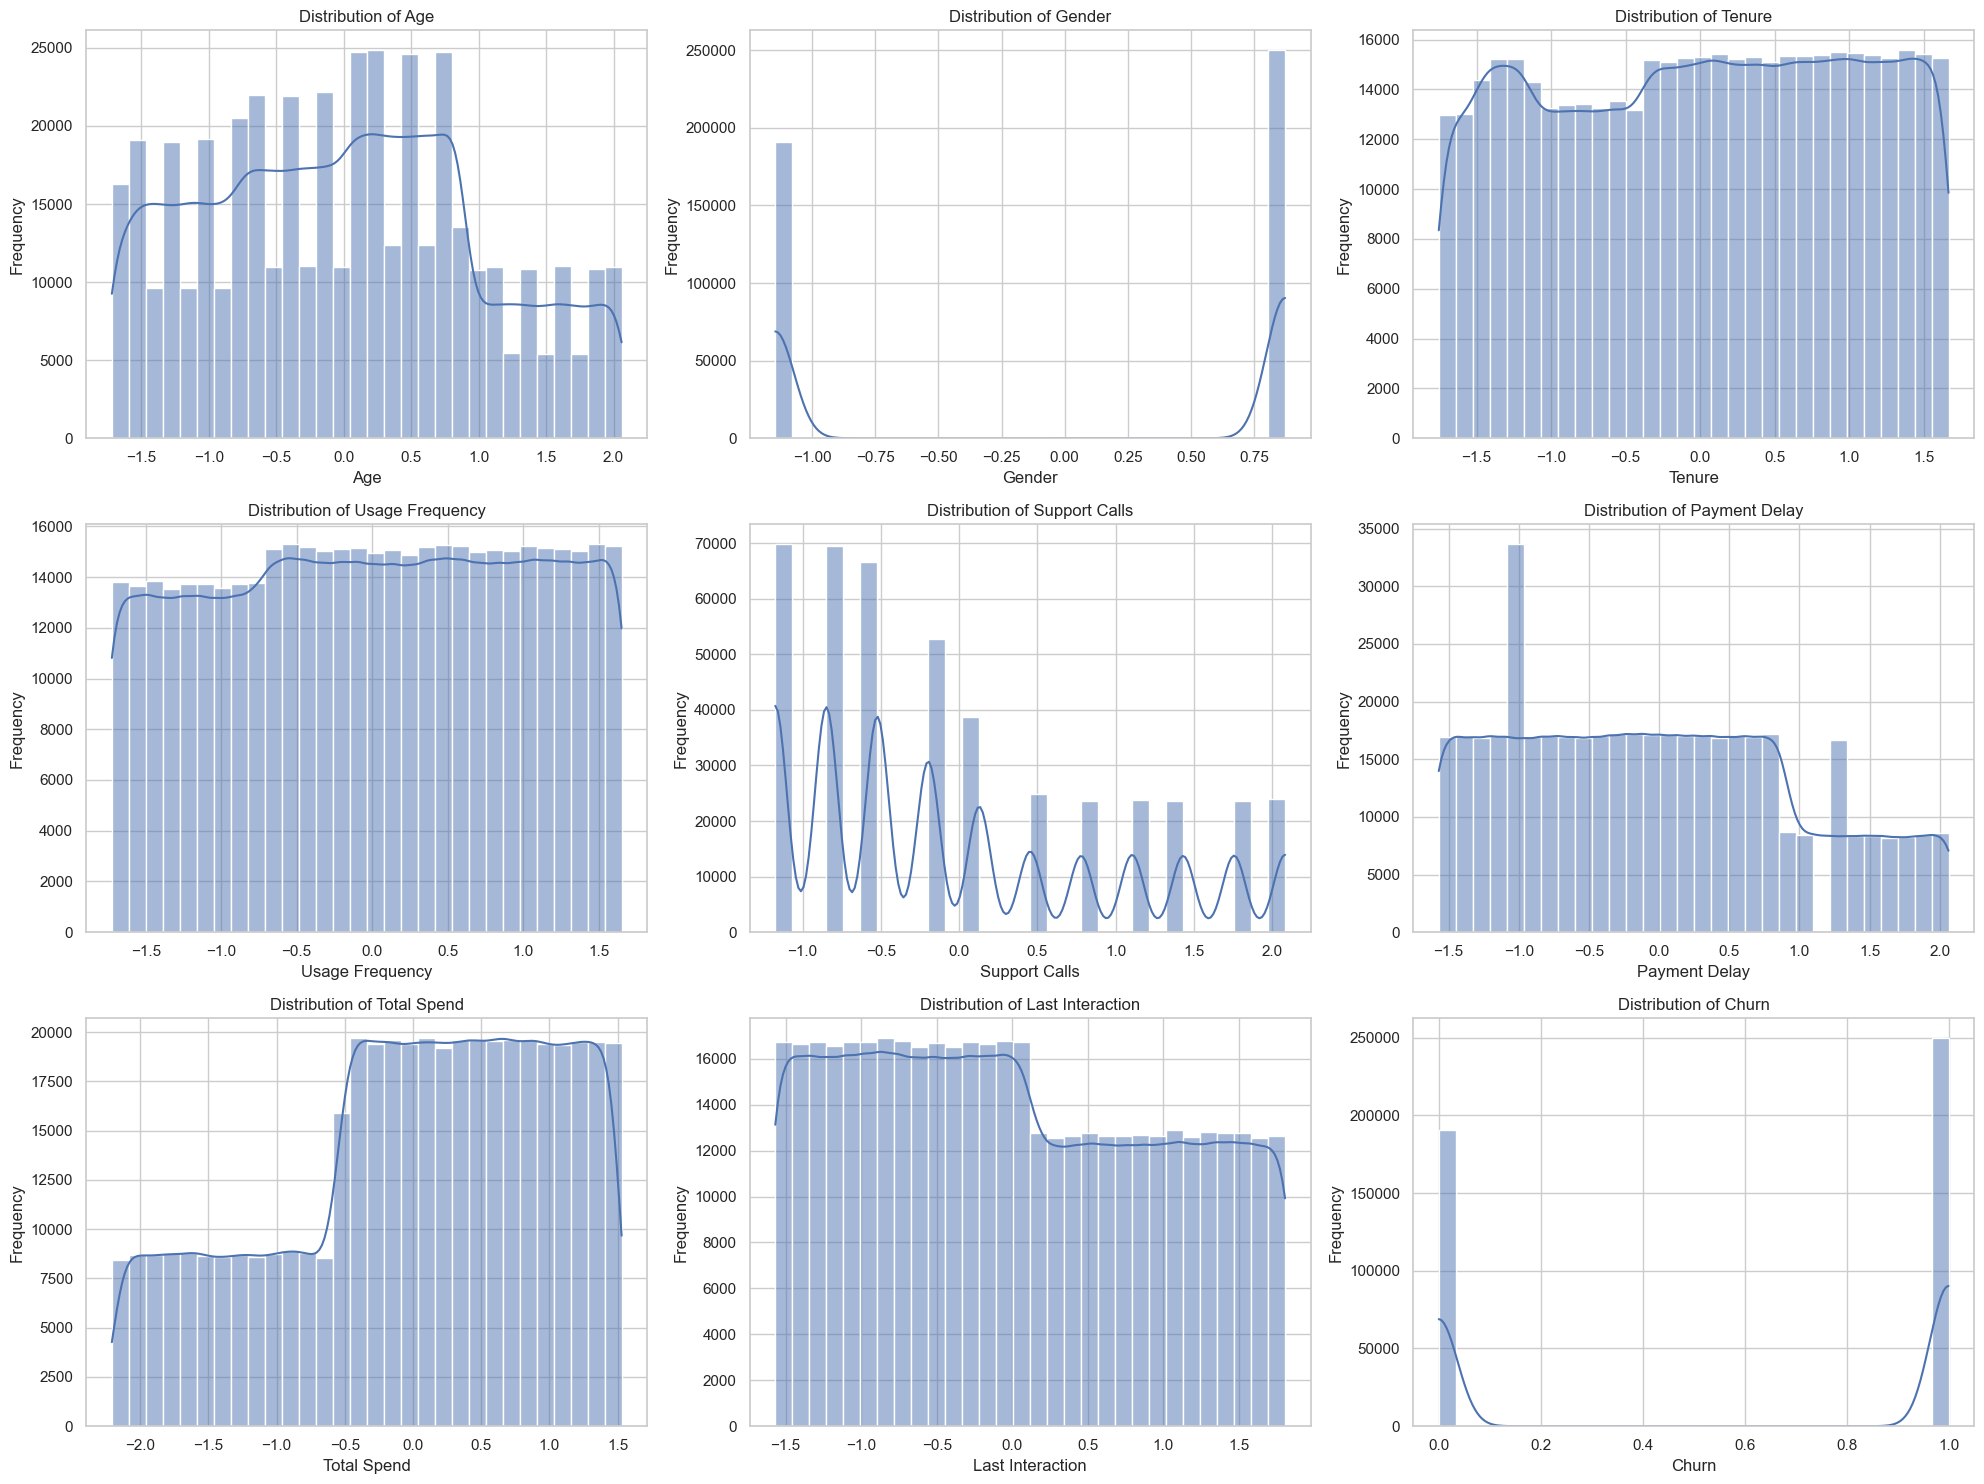

In [23]:
sns.set(style="whitegrid")

plt.figure(figsize=(20, 15))
for i, feature in enumerate(data_train.columns[:-4], 1):
    plt.subplot(3, 3, i)
    sns.histplot(data_train[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Model training

Data split

In [43]:
X_train = data_train.drop(columns=['Churn'])  
y_train = data_train['Churn'] 

X_test = data_test.drop(columns=['Churn'])
y_test = data_test['Churn']

In [50]:
random_forest_model = RandomForestClassifier(random_state=42)

In [85]:
gradboost_model = GradientBoostingClassifier(random_state=42)

### Random forest classifier with not selected optimal features

random_forest_model.fit(X_train, y_train)

In [72]:
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Test Accuracy: 0.5320160313169914
              precision    recall  f1-score   support

           0       0.84      0.14      0.24     33881
           1       0.50      0.97      0.66     30493

    accuracy                           0.53     64374
   macro avg       0.67      0.55      0.45     64374
weighted avg       0.68      0.53      0.44     64374



### Random forest classifier with selected optimal features

In [73]:
selector_random_forest = RFE(random_forest_model, n_features_to_select=6)
selector_random_forest.fit(X_train, y_train)
X_train_rf_selected = selector_random_forest.transform(X_train)
X_test_rf_selected = selector_random_forest.transform(X_test)

In [74]:
random_forest_model.fit(X_train_rf_selected, y_train)

RandomForestClassifier(random_state=42)

In [75]:
y_pred_selected = random_forest_model.predict(X_test_rf_selected)

In [76]:
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_selected))
print(classification_report(y_test, y_pred_selected))

Random Forest Test Accuracy: 0.5534843259701122
              precision    recall  f1-score   support

           0       0.83      0.19      0.31     33881
           1       0.52      0.96      0.67     30493

    accuracy                           0.55     64374
   macro avg       0.67      0.57      0.49     64374
weighted avg       0.68      0.55      0.48     64374



### Class balancing random forest

In [81]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_rf_selected, y_train)

In [82]:
random_forest_model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

In [83]:
y_pred_balanced = random_forest_model.predict(X_test_rf_selected)

In [84]:
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))

Random Forest Test Accuracy: 0.5537794761860378
              precision    recall  f1-score   support

           0       0.83      0.19      0.31     33881
           1       0.52      0.96      0.67     30493

    accuracy                           0.55     64374
   macro avg       0.67      0.57      0.49     64374
weighted avg       0.68      0.55      0.48     64374



### Gradient boosting classifier with not selected optimal features

In [86]:
gradboost_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [87]:
y_pred = gradboost_model.predict(X_test)

In [88]:
print("Gradient Boost Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Gradient Boost Test Accuracy: 0.5383229254046665
              precision    recall  f1-score   support

           0       0.84      0.15      0.26     33881
           1       0.51      0.97      0.67     30493

    accuracy                           0.54     64374
   macro avg       0.67      0.56      0.46     64374
weighted avg       0.68      0.54      0.45     64374



### Gradient boosting classifier with selected optimal features

In [91]:
selector_gradboost = RFE(gradboost_model, n_features_to_select=6)
selector_gradboost.fit(X_train, y_train)
X_train_gb_selected = selector_gradboost.transform(X_train)
X_test_gb_selected = selector_gradboost.transform(X_test)

In [92]:
gradboost_model.fit(X_train_gb_selected, y_train)

GradientBoostingClassifier(random_state=42)

In [93]:
y_pred_selected = gradboost_model.predict(X_test_gb_selected)

In [94]:
print("Gradient Boost Test Accuracy:", accuracy_score(y_test, y_pred_selected))
print(classification_report(y_test, y_pred_selected))

Gradient Boost Test Accuracy: 0.5550688166029764
              precision    recall  f1-score   support

           0       0.83      0.19      0.32     33881
           1       0.52      0.96      0.67     30493

    accuracy                           0.56     64374
   macro avg       0.67      0.58      0.49     64374
weighted avg       0.68      0.56      0.48     64374



### Class balancing gradient boosting

In [95]:
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_gb_selected, y_train)

In [96]:
gradboost_model.fit(X_train_balanced, y_train_balanced)

GradientBoostingClassifier(random_state=42)

In [97]:
y_pred_balanced = gradboost_model.predict(X_test_gb_selected)

In [98]:
print("Gradient Boost Test Accuracy:", accuracy_score(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))

Gradient Boost Test Accuracy: 0.555099885046758
              precision    recall  f1-score   support

           0       0.83      0.19      0.32     33881
           1       0.52      0.96      0.67     30493

    accuracy                           0.56     64374
   macro avg       0.67      0.58      0.49     64374
weighted avg       0.68      0.56      0.48     64374



Classification Task on the Churn Dataset
You need to build and train models to solve the classification task on the Churn dataset.
You should implement the following:

Use at least two methods to solve the classification task, such as:

Tree-based models (e.g., Random Forest, Gradient Boosting)
Multi-Layer Perceptron (MLP)
K-Nearest Neighbors (KNN)
Other classification algorithms (e.g., Logistic Regression, SVM)
Enhance the results of the benchmark models on the test set by:

Optimizing model performance through feature engineering.
Applying techniques like cross-validation to ensure robustness.
Comparing results with baseline models.
Provide deeper analysis for the data and the features. This can include:

Using iterative feature selection methods (e.g., Recursive Feature Elimination).
Selecting features using a correlation threshold to remove highly correlated features.
Exploring new relationships between the target variable and input features through visualization or statistical analysis.
Hyperparameter tuning:

For methods with hyperparameters (e.g., k in KNN, n_estimators in Random Forest), use grid search, random search, or Bayesian optimization to select the best parameters.
